# Survey area vs cadence 

There is an inherent tension between the total area surveyed and the time interval between repeated visits to a single pointing (cadence). This issue is compounded if more than one filter is used.  

The goal of this notebook is to provide some rough guidance on this trade-off.  

In [228]:
import numpy as np
from os import path
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import healpy as hp
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord

# Configure path to local repository
root_dir = '/Users/rstreet/software/rgps'

# HEALpixel grid resolution
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
PIXAREA = hp.nside2pixarea(NSIDE, degrees=True)

The first information we need is the technical capabilities of the spacecraft.  The following constraints are taken from Goddard's [website of technical specifications](https://roman.gsfc.nasa.gov/science/WFI_technical.html) for the mission.  Much more detailed information is also available from the [mission's official documentation](https://roman-docs.stsci.edu/roman-instruments-home).  
Slew and settle times for example, are a function of angular distance to be traveled, so we can interpolate over the data provided.

Text(0, 0.5, 'Slew & settle time [s]')

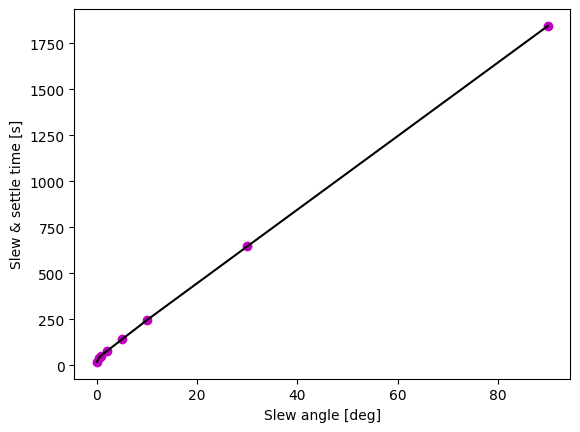

In [6]:
# Data from Roman's Technical Specifications
slew_data = np.array([
    [0.025, 18.9],
    [0.4, 39.3],
    [0.8, 52.5],
    [2.0, 77.8],
    [5.0, 141.0],
    [10.0, 246.0],
    [30.0, 646.0],
    [90.0, 1844.0]
])

# Create interpolated function
slew_func = interp1d(slew_data[:,0], slew_data[:,1])

slew_pred = slew_func(slew_data[:,0])

plt.plot(slew_data[:,0], slew_data[:,1], 'mo')
plt.plot(slew_data[:,0], slew_pred, 'k-')
plt.xlabel('Slew angle [deg]')
plt.ylabel('Slew & settle time [s]')

I looked for, but couldn't immediately find, the expected time taken to change filter, so here I make an educated guess. It may be that this can be performed during slews. 
In addition, integration times can be variable, but for the sake of estimation, I take the 57s integration time used to estimate imaging sensitivity in the resources above. 

In [7]:
filter_change_time = 30.0 # seconds
integration_time = 57.0 # seconds

The other constraint we have is the total number of hours available for the Galactic Plane Survey.

In [18]:
max_gps_time = 700.0 # hrs

## Single filter, wide-area + time-domain surveys

In this simulation, I assume that a visit to a single on-sky pointing consists of n_int integrations in a single filter.  

In [30]:
n_int = 1
n_filters = 1
visit_time = (filter_change_time + integration_time) * n_int
print('Time take for single visit to a single pointing = ' + str(visit_time) + 's')

Time take for single visit to a single pointing = 87.0s


In this simulation, the survey strategy will consist of two components: a wide-area continguous region within which all pointings will recieve n_wide_visits visits plus a smaller, contiguous time-domain region within which all pointings receive n_td_visits.

Firstly, we can calculate the time required to survey the wide-area footprint a minimum number of times.  

In [9]:
# A number of science cases recommended a minimum of 2 visits per pointing 
n_wide_visits = 2.0

# Since we assume that the survey region is contiguous, we can also assume that the telescope 
# will be able to slew from one field directly to next one over, meaning that the slew angular distance will 
# consistently be the approximate width of the Roman WFI field of view (here approximated as a circle).  
# So now we can calculate the slew time required
slew_ang_distance = 0.3 # degrees
slew_time = slew_func(slew_ang_distance)
print('Time to slew from one field to the next: ' + str(slew_time) + 's')

Time to slew from one field to the next: 33.86s


Using this information we can plot how much time it will take to survey different areas of wide-area survey.

In [13]:
def calc_npointings(survey_area):
    """
    Function estimates the expected number of individual field pointings within a survey footprint area, by simply dividing the 
    survey area by the WFI field of view.  Note that no account is taken of dithering.  
    """

    return np.rint(survey_area / 0.28)

Maximum feasible wide-area survey = 7020.738103448275 sq.deg


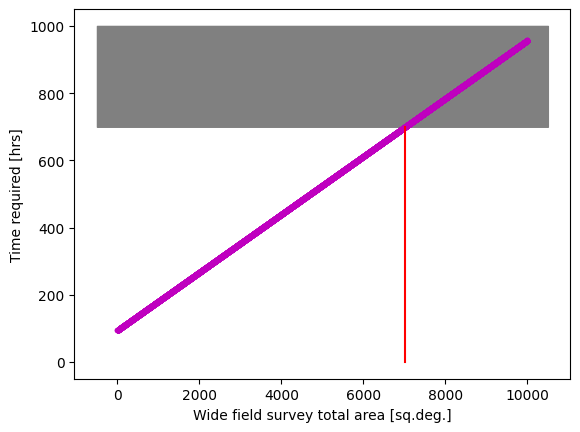

In [67]:
# Explore wide-area survey footprints of different sizes, and infer the number of pointings required
area = np.arange(1.0, 10000.0, 1.0)
npointings = calc_npointings(area)

# Estimate the time required to survey this many pointings in hours
survey_time = (npointings * visit_time + len(npointings)*slew_time) / 3600.0

# Interpolate and project the maximum possible survey area within the maximum allowed time for the GPS
survey_area_func = interp1d(survey_time, area)
max_survey_area = survey_area_func(max_gps_time)
print('Maximum feasible wide-area survey = ' + str(max_survey_area) + ' sq.deg')

plt.plot(area, survey_time, 'm.')
plt.xlabel('Wide field survey total area [sq.deg.]')
plt.ylabel('Time required [hrs]')
[xmin, xmax, ymin, ymax] = plt.axis()
x = np.arange(xmin, xmax, 1.0)
plt.fill_between(x, [max_gps_time]*len(x), y2=[ymax]*len(x), color='grey')
plt.plot([max_survey_area, max_survey_area], [0, max_gps_time], 'r-')

Now we can think about carving out a subregion for a time domain survey.  Obviously, the larger this region is and the more often the visits to this area, the smaller the area of the wide-field survey becomes.  

The next goal is to get a sense for the trade offs between time domain survey area, cadence and wide-field region. 

In [68]:
def calc_time_domain_survey_time_alloc(td_area, n_td_visits, td_visit_time, slew_time):
    """
    Function to estimate the time required for a time domain survey of td_area total area in sq.deg. with n_td_visits per pointing, 
    and taking td_visit_time for each visit.  We assume a contiguous survey region, so slew times can be assumed to be 
    constant - note that this doesn't take into account the need to slew between the time domain and wide area survey regions.
    """

    # Calculate the total number of pointings required
    n_td_pointings = calc_npointings(td_area)
    
    # Calculate total survey time in hours
    td_survey_time = [(((n_td_pointings * td_visit_time + len(n_td_pointings)*slew_time) * nv) / 3600.0).tolist() for nv in n_td_visits]
    
    return np.array(td_survey_time)

Setting the configuration for the time domain survey strategy, we can explore the trade off between the total survey area and number of visits per field...

In [69]:
# The number of visits per field is a proxy for cadence, so let's explore a range
n_td_visits = np.arange(2.0, 100.0, 1.0)

# The total area that we'd like to include in this survey is the other factor to be explored [sq.deg.]
td_area = np.arange(1.0, 100.0, 1.0)

# We assume that the survey region is contiguous, with a consistent slew time between fields. 
# Note that this neglects the additional slew time necessary to switch between time-domain and wide-area fields.
slew_ang_distance = 0.3 # degrees
slew_time = slew_func(slew_ang_distance)

# The duration of a single visit to a time domain survey field, taking the number of filters used and integration time 
# into account
n_int = 1
n_filters = 1
td_visit_time = (filter_change_time + integration_time) * n_int

Text(0, 0.5, 'Total survey time [hrs]')

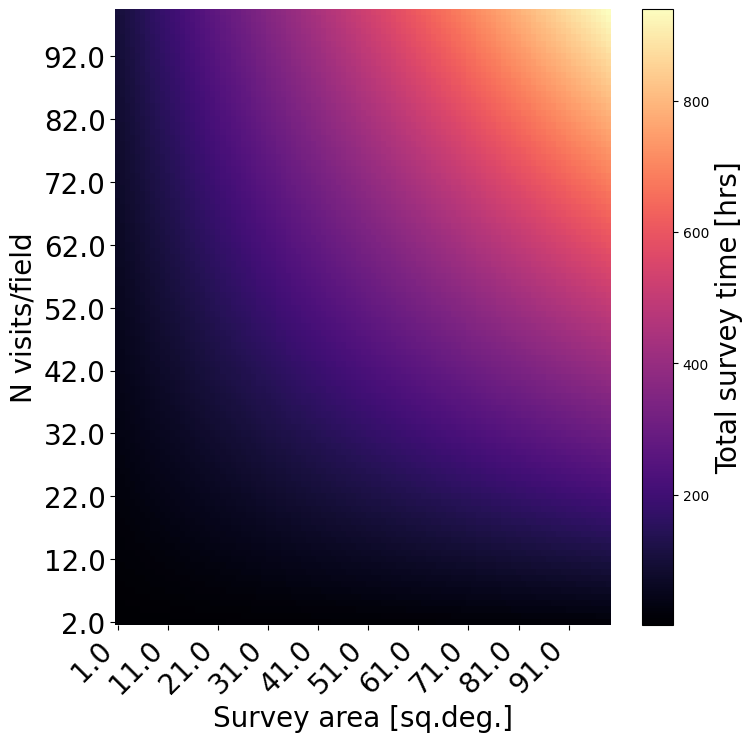

In [85]:
# Calculate survey time taken for the ranges of numbers of visits and survey area 
td_survey_time = calc_time_domain_survey_time_alloc(td_area, n_td_visits, td_visit_time, slew_time)

# Plot a heatmap of the time taken
fig, ax = plt.subplots(figsize=(8,8))

xgrid = np.arange(0,len(td_area)+1,1)
ygrid = np.arange(0,len(n_td_visits)+1,1)
norm = mpl.colors.Normalize(td_survey_time.min(), td_survey_time.max())
immesh = ax.pcolormesh(xgrid, ygrid, td_survey_time, cmap="magma", norm=norm)

ax.set_frame_on(False) # remove all spines

ax.set_xticks(xgrid[0:-1:10]+0.5)
ax.set_yticks(ygrid[0:-1:10]+0.5)
ax.set_xticklabels(td_area[0:-1:10],rotation=45.0,horizontalalignment='right',fontsize=20)
ax.set_yticklabels(n_td_visits[0:-1:10],fontsize=20,horizontalalignment='right')
ax.set_xlabel('Survey area [sq.deg.]', fontsize=20)
ax.set_ylabel('N visits/field', fontsize=20)

cbar = ax.figure.colorbar(immesh, ax=ax)
cbar.ax.set_ylabel('Total survey time [hrs]',  size=20)


Bearing in mind the overall maximum allocated time of 700hrs, this plot makes it clear that only a relatively small time-domain region could be included at a moderate cadence if we also want to perform a wide area survey.  

Next we want to evaluate the trade-offs of allocating different percentags of time to wide-area vs time domain survey.  

For fixed assumptions about visit strategy, we can plot area covered in wide-area and time-domain area as a function of percentage allocation. 

In [249]:
## Survey strategy configuration

# WARNING: This does not yet take dithering or field offsets into account.

# As above, assume we slew from one field to a contiguous field 
slew_ang_distance = 0.3 # degrees
slew_time = slew_func(slew_ang_distance)

## Strategy for wide-area survey 
# The number of visits per field
n_wide_visits = 2.0

# Total duration of all visit to a given field, including slew time to the field
n_wide_int = 1
n_wide_filters = 1
wide_visit_time = ((((filter_change_time + integration_time) * n_wide_int) * n_wide_filters + slew_time) * n_wide_visits) / 3600.0

## Strategy for time-domain survey
# The number of visits per field
n_td_visits = 50.0

# Total duration of all visit to a given time domain survey field, including slew time to the field
n_td_int = 1
n_td_filters = 1
td_visit_time = ((((filter_change_time + integration_time) * n_td_int) * n_td_filters + slew_time) * n_td_visits) / 3600.0


# Calculate survey rate as a point of reference
wide_survey_rate = 1.0/wide_visit_time
td_survey_rate = 1.0/td_visit_time
print('Wide-area survey rate = ' + str(wide_survey_rate) + ' sq.deg. per hour')
print('Time-domain survey rate = ' + str(td_survey_rate) + ' sq.deg. per hour')

Wide-area survey rate = 14.893264934635113 sq.deg. per hour
Time-domain survey rate = 0.5957305973854046 sq.deg. per hour


Given these strategy configurations, we can calculate the survey area that each sub-survey can cover, given different percentages of the total time allocated to the Galactic Plane Survey. 

In [141]:
# Total time for entire Galactic Plane Survey
max_gps_time = 700.0 # hrs

# Fraction of that time allocated to the wide-area and time-domain surveys respectively
frac_wide = np.arange(0.0, 1.0, 0.1)
frac_td = 1.0 - frac_wide
time_wide = max_gps_time * frac_wide
time_td = max_gps_time * frac_td

# Maximum area that can be surveyed by each survey component, given the total fraction of the time available
n_wide_pointings = np.rint(time_wide / wide_visit_time)
n_td_pointings = np.rint(time_td / td_visit_time)
area_wide = n_wide_pointings * 0.28 # sq.deg.
area_td = n_td_pointings * 0.28 # sq.deg.

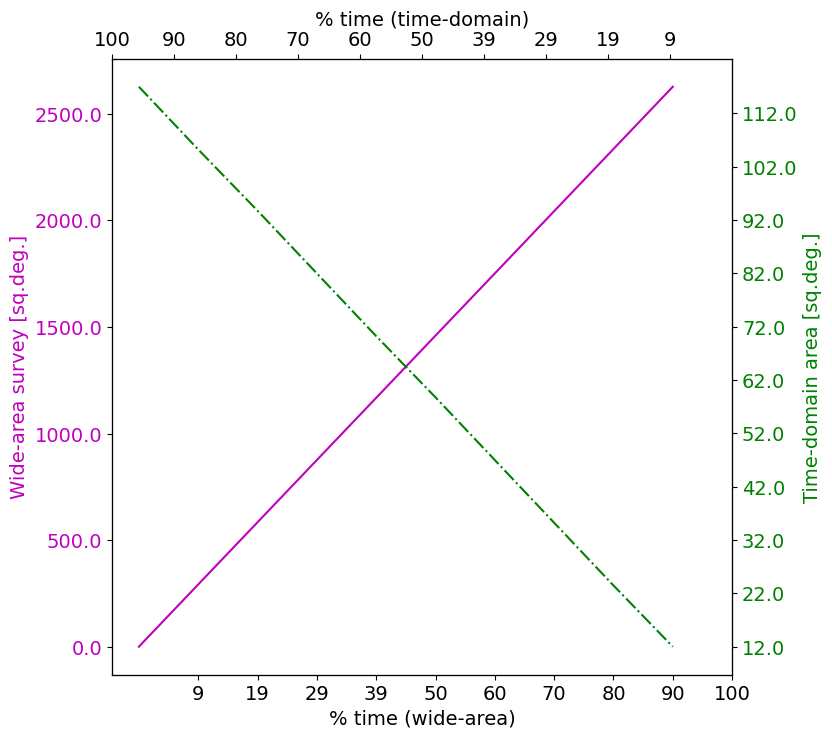

In [145]:
# Plot the area of the different surveys achieved for different time fraction allocations
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Plot area surveyed as a function of fraction allocated to the wide-area
ax.plot(frac_wide*100.0, area_wide, 'm-', label='Wide-area')

ax.set_xlabel('% time (wide-area)', fontsize=14)
ax.set_ylabel('Wide-area survey [sq.deg.]', color='m', fontsize=14)
yticks = np.arange(area_wide.min(), area_wide.max(), 500)
yticklab = [str(round(y,0)) for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklab, color='m', fontsize=14)
xticklab = [str(int(x)) for x in frac_wide*100.0]
ax.set_xticks(frac_wide*100.0)
ax.set_xticklabels(xticklab, fontsize=14) 

# Plot area surveyed as a function of fraction allocated to the time-domain survey on second axis
ax2 = ax.twinx()

# Plot the second dataset on the secondary y-axis
ax2.plot(frac_wide*100.0, area_td, 'g-.', label='Time-domain')

yticks = np.arange(area_td.min(), area_td.max(), 10)
yticklab = [str(round(y,0)) for y in yticks]
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklab, color='g', fontsize=14)
xticklab = [str(int(x)) for x in frac_td*100.0]
ax2.set_xticks(frac_td*100.0)
ax2.set_xticklabels(xticklab, fontsize=14) 
ax2.set_ylabel('Time-domain area [sq.deg.]', color='green', fontsize=14)

# Label the second x-axis
ax3 = ax.twiny()
ax3.set_xlabel('% time (time-domain)', fontsize=14)
xticklab = [str(int(x)) for x in frac_td*100.0]
ax3.set_xticks(frac_td*100.0)
ax3.set_xticklabels(xticklab, fontsize=14) 
ax3.invert_xaxis()

The plot above represents the largest area that can be feasibly surveyed for given wide-area and time-domain strategies, for different proportions of the total Roman GPS time allocation.  

Now we can explore how the survey areas requested by the community compare with these achievable limits.  
We can calculate the total area requested for the wide-area vs the time domain science cases and add this to the plot as follows. 

In [169]:
# Load the configurations for the community requested science
config = config_utils.read_config(path.join(root_dir, 'config', 'rgps_survey_regions.json'))

The next set of functions refactor the code necessary to unpack the information on the regions requested for each science case.

In [229]:
def calc_area_of_region_set(region_list):
    """
    Function to calculate the total area spanned by a set of resolved HEALpixel maps
    """
    combined_map = np.zeros(NPIX)
    
    for r in region_list:
        combined_map += r.region_map
    
    total_area = len(np.where(combined_map > 0.0)[0]) * PIXAREA
    
    return total_area

In [230]:
def calc_visit_time(integration_time, n_integrations, n_filters):
    """
    Function to calculate the time required for a single visit to a given field pointing.
    Note: This function needs to be extended to take account of dithering etc.  Slew time is not included here because it is included 
    later.

    Parameters:
    integration_time  float  Exposure time in seconds
    n_integrations    int    Number of exposures per filter 
    n_filters         int    Number of filters used per visit 

    Returned: 
    visit_time        float  Time required for a single visit to a given field in seconds
    """
    
    filter_change_time = 30.0 # seconds
    
    visit_time = (((filter_change_time + integration_time) * n_integrations) * n_filters) / 3600.0

    return visit_time

In [231]:
def calc_survey_time_required(area, n_visits, visit_time, slew_time):
    
    # Calculate the total number of pointings required
    n_pointings = calc_npointings(area)
    
    # Calculate total survey time in hours
    survey_time = ((n_pointings * visit_time + n_pointings*slew_time) * n_visits) / 3600.0
    
    return survey_time

In [232]:
def extract_requested_regions(science_cases):
    """
    Function to extract the region configuration for a set of science cases, sorted by author's name
    """
    optical_components = ['F087', 'F106', 'F129', 'F158', 'F184', 'F213', 'F146', 'G150', 'P127']
    
    requested_regions = {author: [] for author in science_cases.keys()}

    for author in science_cases.keys():
        info = config[author]
        if info['ready_for_use']:
            for optic in optical_components:
                if optic in info.keys():
                    for region in info[optic]:
                        region['label'] = author
                        region['optic'] = optic
                        requested_regions[author].append(region)
    
    return requested_regions

In [233]:
def build_regions_per_science_case(requested_regions): 
    """
    Function to build a set of CelestialRegion objects for each sky region in the configuration for each science case
    """
    
    desired_regions = {}
    for author, region_list in requested_regions.items():
        regions_for_author = []
        for box in region_list:
            if 'catalog' in box.keys():
                region_set = regions.create_region_set(box)
            else:
                region_set = [ regions.create_region(box) ]
    
            for r in region_set:
                # If the region is valid, the list of included pixels will be non-zero. 
                # Each pixel within a region is given a value of 1 - essentially being a 'vote' for that pixel, 
                # for each science case.
                if len(r.pixels) > 0:
                    r.pixel_priority = np.zeros(r.NPIX)
                    r.pixel_priority[r.pixels] = 1.0
                    r.predefined_pixels = True
                    r.make_map()
                    
                    regions_for_author.append(r)
            
        desired_regions[author] = regions_for_author

    return desired_regions

Now we can extract the sky regions requested for each science case, categorized as wide-area or time-domain science.

In [234]:
# Categorizing all science cases as either wide-area or time-domain, 
# calculate the survey area requested, and extract the number of filters requested. 

# Distinguish between the two categories of science case, and create dictionaries of the configurations
time_domain_science = {author: info for author, info in config.items() if info['time_domain']}
wide_area_science = {author: info for author, info in config.items() if not info['time_domain']}

# Extract the regions requested for time domain versus wide-area surveys
requested_td_regions = extract_requested_regions(time_domain_science)
requested_wide_regions = extract_requested_regions(wide_area_science)

# Build a set of CelestialRegion objects for each of the sets of science cases, so that we can use 
# the object's built-in methods for mapping sky regions 
desired_td_regions = build_regions_per_science_case(requested_td_regions)
desired_wide_regions = build_regions_per_science_case(requested_wide_regions)

In [235]:
# If we had absolute numbers of visits requested for each science case, we could also estimate the total time required.  
# This information is available for only some of the time-domain cases, but for those cases we can calculate the percentage of 
# survey time required. 
integration_time = 57 # seconds

td_survey_areas = []
td_survey_times = []
for author, region_list in desired_td_regions.items():
    info = config[author]
    if info['time_domain'] and 'n_visits_per_field' in info.keys():
        # Calculate total area in all requested regions
        area_req = calc_area_of_region_set(region_list)
        
        # Calculate the time required per visit given the number of filters requested by the author
        n_filters = len([f for f in optical_components if f in info.keys()])        
        visit_time = calc_visit_time(integration_time, 1, n_filters)

        # Calculate the time required for this strategy - this needs to be as a fraction of the 
        # maximum time available, i.e.g 700hrs
        time_req = calc_survey_time_required(area_req, info['n_visits_per_field'], visit_time, slew_time)

        td_survey_areas.append(area_req)
        td_survey_times.append((time_req/max_gps_time)*100.0)
td_survey_areas = np.array(td_survey_areas)
td_survey_times = np.array(td_survey_times)

# The situation is more complicated for wide-area survey science, most of which did not specify numbers of visits.  
# Here we assume a set number of visits per field, which can be experimented with later.
n_visits_per_field = 2
wide_survey_areas = []
wide_survey_times = []
for author, region_list in desired_wide_regions.items():
    info = config[author]
    
    # Calculate total area in all requested regions
    area_req = calc_area_of_region_set(region_list)
    
    # Calculate the time required per visit given the number of filters requested by the author
    n_filters = len([f for f in optical_components if f in info.keys()])        
    visit_time = calc_visit_time(integration_time, 1, n_filters)

    # Calculate the time required for this strategy - this needs to be as a fraction of the 
    # maximum time available, i.e.g 700hrs
    time_req = calc_survey_time_required(area_req, n_visits_per_field, visit_time, slew_time)

    wide_survey_areas.append(area_req)
    wide_survey_times.append((time_req/max_gps_time)*100.0)
wide_survey_areas = np.array(wide_survey_areas)
wide_survey_times = np.array(wide_survey_times)

Now let's replot the above graph, this time showing the time and areas requested by the community science cases.

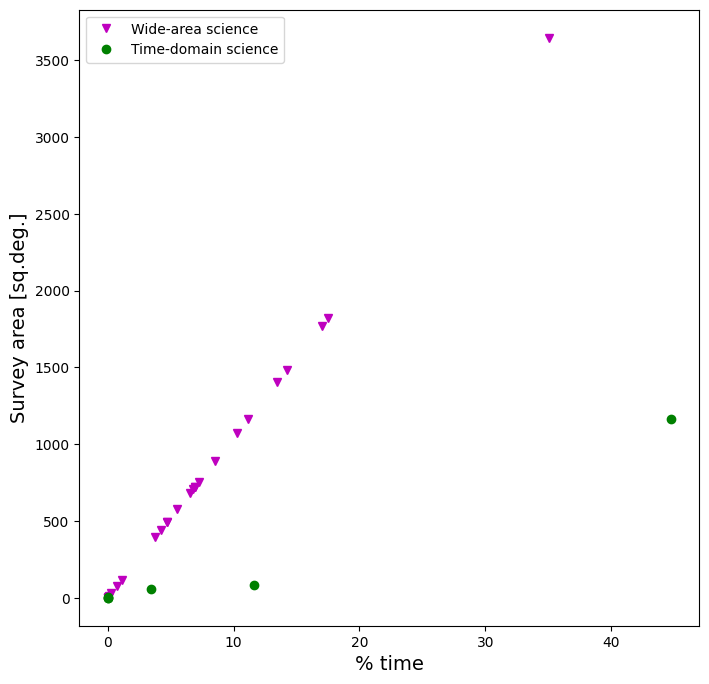

In [243]:
# Plot the area of the different surveys achieved for different time fraction allocations
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.set_xlabel('% time', fontsize=14)
ax.set_ylabel('Survey area [sq.deg.]', color='k', fontsize=14)

# Plot the requirements of the community time-domain and wide-area surveys
ax.plot(wide_survey_times, wide_survey_areas, 'mv', label='Wide-area science')
ax.plot(td_survey_times, td_survey_areas, 'go', label='Time-domain science')
ax.legend(loc='upper left')

The graph above represents the sky area and percentage of time available that would be required to perform the surveys as requested in the White Papers and Science Pitches, if the nominal survey strategies described above were followed.  